1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [2]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2023-11-18 15:42:42--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2023-11-18 15:42:43--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6ea041c4ddbc713ca4df8d05ff.dl.dropboxusercontent.com/cd/0/inline/CHzBFD_AzCbpCe6PawT2LaC7wnFwokCwtvPWpIoR3mgjw5WM8FlFH1Fi8CIPJCPx4hE8xU3cz6IQ1SDwtgFax7N25V0zwNFHaOh78EtVHOUU5grFZwZtve_f3OL4lQSQCBQ/file# [following]
--2023-11-18 15:42:43--  https://uc6ea041c4ddbc713ca4df8d05ff.dl.dropboxusercontent.com/cd/0/inline/CHzBFD_AzCbpCe6PawT2LaC7wnFwokCwtvPWpIoR3mgjw5WM8FlF

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [64]:
import numpy as np
import pandas as pd

file_name = "./data/data_000637.txt"
df = pd.read_csv(file_name,nrows=100000)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
99995,1,0,64,3869201161,2378,29
99996,1,0,70,3869201161,2472,26
99997,1,0,58,3869201161,2558,0
99998,1,0,57,3869201161,2561,23


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [172]:
x = df['BX_COUNTER'].max()
print("The estmiate number of BX in a ORBIT is:",x)

The estmiate number of BX in a ORBIT is: 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [178]:
df['ABS_TIME[ns]'] = df['ORBIT_CNT']*x*25 + df['BX_COUNTER']*25 + df['TDC_MEAS']*25/30
df['ABS_TIME[ns]'] -= df['ABS_TIME[ns]'].iloc[0]

abs_tstamp = pd.Series(df['ABS_TIME[ns]'].values, index=df.index)

print("Absolute time in ns since the beginning of the ata acquisition:\n",abs_tstamp)

Absolute time in ns since the beginning of the ata acquisition:
 0        0.000000e+00
1        8.125000e-01
2        4.476625e+03
3        4.594125e+03
4        9.649125e+03
             ...     
99995    8.854065e+07
99996    8.854300e+07
99997    8.854513e+07
99998    8.854522e+07
99999    8.854531e+07
Length: 100000, dtype: float64


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [179]:
ts = pd.to_datetime(abs_tstamp,unit='ns').max()

print(f"Duration of the data taking: {ts.hour} hours, {ts.minute} minutes and {ts.second+ts.microsecond*10**-6+ts.nanosecond*10**-9} seconds")

Duration of the data taking: 0 hours, 0 minutes and 0.088545313 seconds


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [184]:
noisy_ch = df.groupby('TDC_CHANNEL')['ORBIT_CNT'].count().sort_values(ascending=False)

print("The top 3 noisy channels are:",noisy_ch[:3])

The top 3 noisy channels are: TDC_CHANNEL
139    8320
64     5027
63     4917
Name: ORBIT_CNT, dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [205]:
nonempty_orbits = df.groupby('ORBIT_CNT').size().count()
print(f"There are {nonempty_orbits} non-empty orbits")

There are 995 non-empty orbits


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [206]:
unique_orbit_ch = df[df['TDC_CHANNEL'] == 139]['ORBIT_CNT'].nunique()
print(f"There are {unique_orbit_ch} unique orbits with at least one measurement from TDC_CHANNEL = 139")

There are 994 unique orbits with at least one measurement from TDC_CHANNEL = 139


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [221]:
fpga0 = df[df['FPGA'] == 0]['TDC_CHANNEL'].value_counts()
fpga1 = df[df['FPGA'] == 1]['TDC_CHANNEL'].value_counts()

print("Time series for FPGA = 0\n", fpga0)
print("\nTime series for FPGA = 1\n", fpga1)

Time series for FPGA = 0
 139    5831
64     4916
63     4845
61     3736
62     3652
       ... 
103      24
67       11
130       2
137       2
138       2
Name: TDC_CHANNEL, Length: 121, dtype: int64

Time series for FPGA = 1
 139    2489
2      2444
1      2116
4      2014
3      1670
       ... 
9         9
130       4
138       2
137       2
129       2
Name: TDC_CHANNEL, Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

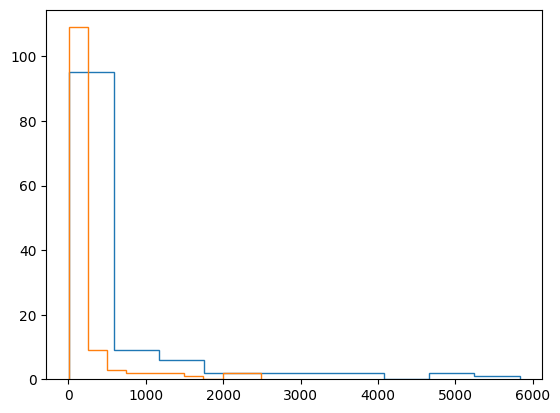

In [170]:
import matplotlib.pyplot as plt

counts, bins = np.histogram(fpga0)
plt.stairs(counts, bins)

counts, bins = np.histogram(fpga1)
plt.stairs(counts, bins)